## Image Classification - Fashion MNIST

The following models will be run on the Fashion MNIST data set(https://github.com/zalandoresearch/fashion-mnist): 

#### Visualization

First, the packages used are imported along with the X_train and y_train splits.

In [44]:
#import packages, data
import time
import imageio
import numpy as np
import mnist_reader
from scipy import io
from sklearn import svm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import neighbors
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

#Load data
X_train, y_train = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='t10k')

#Confirm training and testing data shape. 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


To visualize each piece of clothing, the arrays are reshaped to 60000 x 28 x 28, then plotted from each class.

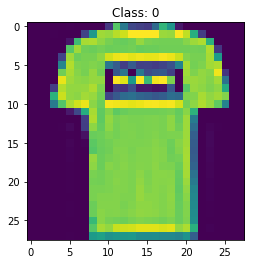

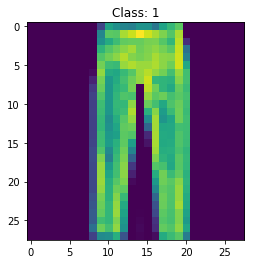

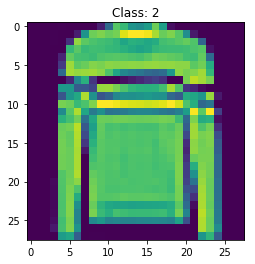

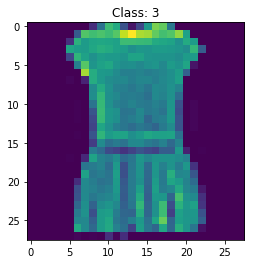

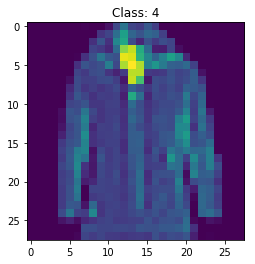

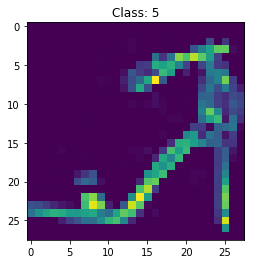

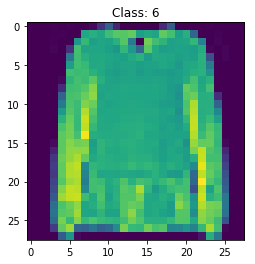

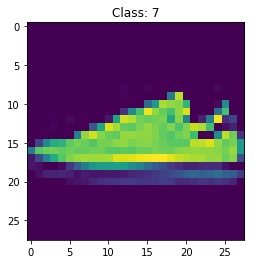

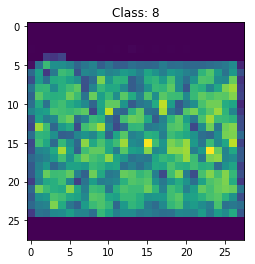

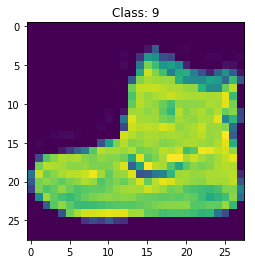

In [2]:
#reshape to 3-Dimensional array
X_train_vis = X_train.reshape(60000, 28, 28)
#loop through and plot one image from each class
for i in range(10):
    index = np.where(y_train == i)[0][0]
    plt.imshow(X_train_vis[index])
    plt.title('Class: {}'.format(i))
    plt.show()

#### Logistic Regression

To test for speed and model accuracy, the model will be fit to non-scaled data first, then on data scaled using a standard scaler. 

In [ ]:
#Fit to default settings
start = time.time()
log_model = linear_model.LogisticRegression()
log_model.fit(X_train, y_train)
end = time.time()
print('The training accuracy is: {}%'.format(log_model.score(X_train, y_train)))
print('The test accuracy is: {}%'.format(log_model.score(X_test, y_test)))
print('Time to execute cell:', end-start, 's')

In [5]:
#Normalize data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

c:\users\b\venv\tensor35\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
#fit log model to scaled data
start = time.time()
log_model = linear_model.LogisticRegression()
log_model.fit(X_train_norm, y_train)
end = time.time()
print('The normalized training accuracy is: {}%'.format(log_model.score(X_train, y_train)))
print('The normalized test accuracy is: {}%'.format(log_model.score(X_test, y_test)))
print('Time to execute cell:', end-start, 's')

The normalized training accuracy is: 0.7813%
The normalized test accuracy is: 0.7574%
Time to execute cell: 687.4500522613525 s


As we see from our results, overall the logistic regression model performs quite well, even on a reduced data set, achieving an accuracy of 85% on non-transformed data and 87% on scaled. The next step would be to use a much larger training set and running it for a longer period of time to see how the accuracy is improved with a greater sample size. <br>

Overall, the models run faster when the data is normalized with a standard scaler, at around 85 seconds runtime, compared to around 355 seconds without scaling. Next we see if reducing the dimensions will affect the time it takes to run or accuracy. <br>

####  What is one advantage and disadvantage of each method?

Scaling the values will help with data that might vary among its unit features, for example, comparing a set measured in millimeters vs in kilometers. The relationships between the values in the feature may not directly be comparable. The scaled data better represents the relationships between sets with varying units. A drawback in scaling data is the magnitude of some relationships may be lost and model accuracy may suffer. 

A PCA will help by reducing dimensions and speeding up a model. However, as demonstrated below, this has the potential to strongly affect model accuracy, as the PCA values are essentially new features derived from other features in the data set. As the components decrease, the speed of the model will increase, however accuracy should suffer as features get reduced closer to 1.

To find a good number of dimensions to use on our PCA model, a series of regressions on different numbers of n_compenents are run to visualize ideal values.

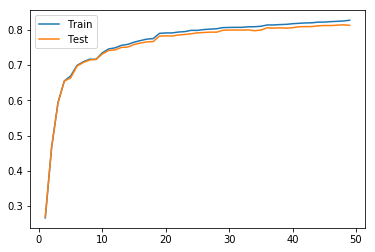

In [9]:
#run through range of values for n_components
train_score_pca = []
test_score_pca = []
pca_range = np.arange(1,50)
for i in pca_range:
    #fit model, loop though dimensions
    pca_model = PCA(n_components=i)
    pca_model.fit(X_train_norm)
    #transform normalized data
    X_train_pca = pca_model.transform(X_train_norm)
    X_test_pca = pca_model.transform(X_test_norm)
    #fit to model
    log_model = linear_model.LogisticRegression()
    log_model.fit(X_train_pca, y_train)
    #append scores to list for plotting
    train_score_pca.append(log_model.score(X_train_pca,y_train))
    test_score_pca.append(log_model.score(X_test_pca,y_test))

#plot the results
plt.plot(pca_range, train_score_pca, label = "Train")
plt.plot(pca_range, test_score_pca, label = "Test")
plt.legend()
plt.show;

As shown, applying ranges of the PCA n_components quickly improves its testing accuracy from 1 through 15, then marginally improves until our range limit of 50. We will use 50 as our value moving on to the next step, as it has a high accuracy.

Next a PCA is ran with 50 dimensions and timed for efficiency. 

In [6]:
#pca transform only training data
pca_model = PCA(n_components=19)
pca_model.fit(X_train_norm)
X_train_pca = pca_model.transform(X_train_norm)
X_test_pca = pca_model.transform(X_test_norm)

In [5]:
#fit log reg to PCA/reduced dimension data
start = time.time()
log_model = linear_model.LogisticRegression()
log_model.fit(X_train_pca, y_train)
end = time.time()
print('The pca training accuracy is: {}%'.format(log_model.score(X_train_pca, y_train)))
print('The pca test accuracy is: {}%'.format(log_model.score(X_test_pca, y_test)))
print('Time to execute cell:', end-start, 's')

The pca training accuracy is: 0.79015%
The pca test accuracy is: 0.7822%
Time to execute cell: 15.488252401351929 s


Fitting a PCA on scaled data was much faster to run, at around 3 seconds. The PCA is much faster than the scaled data, whereas both are magnitudes faster than on non-transformed data. As more data is introduced using our models, the run times would become even more dramatic. <br>

The testing accuracy was 88%, showing a percentage improvement over our logistic regression on just the normalized data. The clear benefit to a pca analysis is reducing the runtime to fit to the model without sacrificing too much accuracy; however as the dimensions get reduced closer to 2 there is a stark drop of accuracy. 

### Question 3
#### KNN Model

#### Use 5 fold cross validation for various values of K (try K from 1 to 15) in KNN to find the ideal K value to model the data.

Acting on the reduced X_train set, first we explore a KNN model by running 5-fold validation on a standard KNN. For this set the data is normalized but not run with a PCA. 

In [5]:
#Assign KNN model to variable
KNN_model = KNeighborsClassifier()
scores = cross_val_score(KNN_model, X_train_norm, y_train, cv = 5)
for i in range(len(scores)) :
    print("Fold %i: %3.3f" % (i ,scores[i]))

Fold 0: 0.857
Fold 1: 0.850
Fold 2: 0.856
Fold 3: 0.857
Fold 4: 0.853


These scores look promising with a K = 3 of 93%, so next we'll graph performance over a range of 1-15 K neighbours. 

In [ ]:
#Store the results
validation_score_list = []
K_range = np.arange(1,16)

#Cross validation over a range of K
for i in K_range:
    model = KNeighborsClassifier(n_neighbors=i)
    validation_score = np.mean(cross_val_score(model, X_train_norm, y_train, cv = 5))
    validation_score_list.append(validation_score)

Now it's ran (12+ hours!), let's plot out the scores.

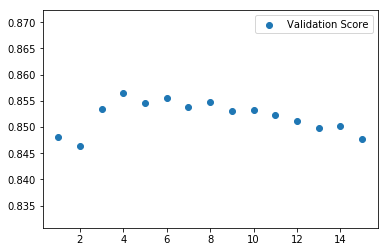

Best Model:  4


In [24]:
#Scatter plot
plt.scatter(K_range, validation_score_list,label="Validation Score")
plt.legend();
plt.show();
#Best model
print("Best Model: ", validation_score_list.index(np.max(validation_score_list))+1)

The best K from our cross validation was 3 with an accuracy of 93%. As the neighbours increased, the model began to lose accuracy. Next we test a KNN with that K value on both scaled and regular training data to compare performance. 

In [25]:
#fit model to X_train
KNN_model = neighbors.KNeighborsClassifier(n_neighbors=4)
KNN_model.fit(X_train, y_train)

print('The training accuracy is: {}%'.format(KNN_model.score(X_train, y_train)))
print('The test accuracy is: {}%'.format(KNN_model.score(X_test, y_test)))

The training accuracy is: 0.9082166666666667%
The test accuracy is: 0.8577%


In [26]:
#fit model to X_train normalized
KNN_model = neighbors.KNeighborsClassifier(n_neighbors=4)
KNN_model.fit(X_train_norm, y_train)

print('The training accuracy is: {}%'.format(KNN_model.score(X_train_norm, y_train)))
print('The test accuracy is: {}%'.format(KNN_model.score(X_test_norm, y_test)))

The training accuracy is: 0.91095%
The test accuracy is: 0.8543%


From running these tests it shows that a KNN with a K value of 3 performs the best in scoring accuracy on our non-normalized data. Without transformation the test data achieved an accuracy of 94% and on normalized test set it obtained 90%.

#### Decision Trees

To compare between clustering models, we'll use a decision tree and iterate through varying depths of the tree like in our previous KNN example. First, we run a DT with a max depth of 1, followed by a max_depth = len(X_train). The DT model runs faster than the KNN and iterating through depths does not consume as much computer performance.  <br>

In [7]:
from sklearn import tree
#fit model to max_depth=1
DT_model = tree.DecisionTreeClassifier(max_depth=25)
DT_model.fit(X_train, y_train)

print('The training accuracy is: {}%'.format(DT_model.score(X_train, y_train)))
print('The test accuracy is: {}%'.format(DT_model.score(X_test, y_test)))

The training accuracy is: 0.9945666666666667%
The test accuracy is: 0.7937%


In [9]:
#fit model to max_depth=len(X_train)
dt_range = len(X_train)
DT_model = tree.DecisionTreeClassifier(max_depth=dt_range)
DT_model.fit(X_train, y_train)

print('The training accuracy is: {}%'.format(DT_model.score(X_train, y_train)))
print('The test accuracy is: {}%'.format(DT_model.score(X_test, y_test)))

The training accuracy is: 1.0%
The test accuracy is: 0.7889%


As expected, both models were ill-fit to score our testing data. The low depth showed an incapibility to predict either train or testing data. Conversely, running a DT on the max length of X_train clearly leaves to overfitting as the training accuracy is maxed out at 100% and the training is approaching 80%.

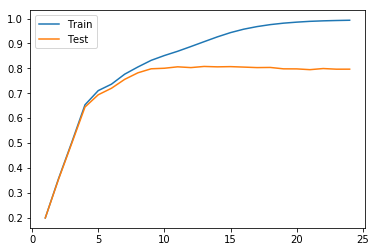

In [10]:
#fitting the DT
from sklearn import tree

train_score_dt = []
test_score_dt = []
depths = range(1,25)
for i in depths:
    my_tree = tree.DecisionTreeClassifier(max_depth=i)
    my_tree.fit(X_train, y_train)
    train_score_dt.append(my_tree.score(X_train,y_train))
    test_score_dt.append(my_tree.score(X_test,y_test))

plt.plot(depths, train_score_dt, label = "Train")
plt.plot(depths, test_score_dt, label = "Test")
plt.legend()
plt.show;

In [12]:
test_score_arr_dt = np.array(test_score_dt)
test_val = test_score_arr_dt.argmax()+1
print ('Optimal depth of DT: {0}, {1}%'.format(test_val,test_score_arr_dt[15]))

Optimal depth of DT: 13, 0.805%


As shown above, the DT model performed fairly well acheiving an accuracy of 79% with an optimal depth of 12. After this point our model appears to overfit and levels out, as the training set indicating about 100% accuracy and our testing accuracy does not improve. This happens as the associations made by the model become too specific (low variance, high bias), as the depth increases on our train set. When we score the testing portion, the overfit DT will be unable to make improvments and we see this by the testing accuracy plateau. 

#### Random Forest

Next, we'll try random forests

#### SVM

#### Fit an logistic regression or SVM and aim for highest accuracy on a 70-30 split. What does the class confusion matrix look like for your best model? 
Re-import the X_train and test data to refit a new SVM model.

In [8]:
#import the packages for SVM
from sklearn.svm import LinearSVC

In [9]:
#fit model on PCA data
SVM_model = LinearSVC()
SVM_model.fit(X_train_pca,y_train)

print('The pca training accuracy is: {}%'.format(SVM_model.score(X_train_pca, y_train)))
print('The pca test accuracy is: {}%'.format(SVM_model.score(X_test_pca, y_test)))

The pca training accuracy is: 0.7648333333333334%
The pca test accuracy is: 0.7558%


In [10]:
#fit SVM model to scaled data
SVM_model = LinearSVC()
SVM_model.fit(X_train_norm, y_train)
print('The normalized training accuracy is: {}%'.format(SVM_model.score(X_train_norm, y_train)))
print('The normalized test accuracy is: {}%'.format(SVM_model.score(X_test_norm, y_test)))

The normalized training accuracy is: 0.8659333333333333%
The normalized test accuracy is: 0.832%


From our two SVM models we ran, we've achieved 88% and 90% on pca&normalized vs just normalized testing data, respectively. The next step we can do to improve our model accuracy is re-run our SVM with a wide range of C to observe any changes in accuracy we may have. Once we find an ideal C we can rerun our SVMs with the new value.  

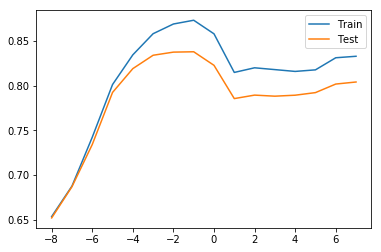

In [11]:
train_svm = []
test_svm = []

c_range = float(10)**np.arange(-8,8)

for i in c_range:
    SVM_model = LinearSVC(C=i)
    SVM_model.fit(X_train_norm, y_train)
    train_svm.append(SVM_model.score(X_train_norm, y_train))
    test_svm.append(SVM_model.score(X_test_norm, y_test))
    
plt.plot(np.log10(c_range),train_svm, label='Train')
plt.plot(np.log10(c_range),test_svm, label='Test')
plt.legend()

In [12]:
#Find optimal C
test_score_svm = np.array(test_svm)
test_val = test_score_svm.argmax()
print ('Optimal C in SVM: {0}, {1}%'.format(test_val, test_score_svm[6]))

Optimal C in SVM: 7, 0.8377%


In [10]:
#fit SVM with C=0.01 to PCA
SVM_model = LinearSVC(C=0.01)
SVM_model.fit(X_train_pca,y_train)

print('The pca training accuracy is: {}%'.format(SVM_model.score(X_train_pca, y_train)))
print('The pca test accuracy is: {}%'.format(SVM_model.score(X_test_pca, y_test)))

The pca training accuracy is: 0.872452380952381%
The pca test accuracy is: 0.849%


In [39]:
#fit SVM with C=0.01 to normalized
SVM_model = LinearSVC(C=0.01)
SVM_model.fit(X_train_norm, y_train)
print('The normalized training accuracy is: {}%'.format(SVM_model.score(X_train_norm, y_train)))
print('The normalized test accuracy is: {}%'.format(SVM_model.score(X_test_norm, y_test)))

The normalized training accuracy is: 0.8725%
The normalized test accuracy is: 0.8498333333333333%


As indicated from our models, there was not much improvement in our testing model accuracy. Our PCA scaled data remained at 88% but there was a slight 1% increase in our normalized set, at 91%. 

Now we have our best performing model, SVM with C=0.01 on normalized training data, we can take a look into the confusion matrix and produce a heatmap to compare features. 

In [11]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, SVM_model.predict(X_test))
print(confusion)

[[  5   0   0   0 987   0   0   3   0   5]
 [  0   0   0   1 997   0   0   0   0   2]
 [  1   0   0   0 986   0   0   3   0  10]
 [  0   0   0   0 996   0   0   0   0   4]
 [  0   0   0   0 995   0   3   2   0   0]
 [ 26  10   1  92 309   0  88 106  18 350]
 [  1   0   0   0 990   0   3   1   0   5]
 [  3   4   0 163 398   0 156  85   6 185]
 [  2   0   0   3 814   0   1   1   0 179]
 [  0   0   0  15 954   0   0   2   0  29]]


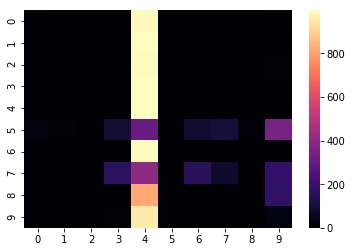

In [18]:
import seaborn as sns
#visualize the confusion matrix
sns.heatmap(confusion, cmap='magma')

This heatmap above shows the correlations bewtween features in our model, highlighting low correlations amongst the data classes. Class 8 and class 5 appear to be slightly correlated, which makes sense given the general shapes of the numbers are similar. 

In [24]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import to_categorical

In [26]:
#reshape images
train_images = X_train.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = X_test.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255
#prepare labels
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

In [40]:
# define and fit the model
model = Sequential()
model.add(Dense(512, input_dim=784, activation='relu'))
# model.add(Dense(500, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(train_images, train_labels, epochs=100, batch_size=128)

Epoch 1/100
60000/60000 [==============================] - 4s 74us/step - loss: 0.5049 - acc: 0.8223
Epoch 2/100
60000/60000 [==============================] - 4s 64us/step - loss: 0.3640 - acc: 0.8673
Epoch 3/100
60000/60000 [==============================] - 4s 64us/step - loss: 0.3283 - acc: 0.8795
Epoch 4/100
60000/60000 [==============================] - 4s 65us/step - loss: 0.3033 - acc: 0.8865
Epoch 5/100
60000/60000 [==============================] - 4s 64us/step - loss: 0.2833 - acc: 0.8954
Epoch 6/100
60000/60000 [==============================] - 4s 65us/step - loss: 0.2698 - acc: 0.8991
Epoch 7/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.2559 - acc: 0.9039
Epoch 8/100
60000/60000 [==============================] - 4s 67us/step - loss: 0.2434 - acc: 0.9095
Epoch 9/100
60000/60000 [==============================] - 4s 66us/step - loss: 0.2361 - acc: 0.9103
Epoch 10/100
60000/60000 [==============================] - 4s 65us/step - loss: 0.2297 - a

In [43]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

10000/10000 [==============================] - 1s 104us/step
test_acc: 0.8931


### Decision Trees and Boosting Methods
The following final tests will compare decision tree-based methods as well as boosting classifiers. This


In [46]:
# import classifiers
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# set model
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
ab = AdaBoostClassifier()
gb = GradientBoostingClassifier()
xgb = XGBClassifier()

# fit model to scaled data
dt.fit(X_train_norm,y_train)
rf.fit(X_train_norm,y_train)
ab.fit(X_train_norm,y_train)
gb.fit(X_train_norm,y_train)
xgb.fit(X_train_norm,y_train)

print("Test Set Scores:\n")
print("Decision Tree score: %3.3f"  % (100 * dt.score(X_test_norm,y_test)))
print("Random Forest score: %3.3f"  % (100 * rf.score(X_test_norm,y_test)))
print("AdaBoost score: %3.3f"       % (100 * ab.score(X_test_norm,y_test)))
print("Gradient Boost score: %3.3f" % (100 * gb.score(X_test_norm,y_test)))
print("XG Boost score: %3.3f"       % (100 * xgb.score(X_test_norm,y_test)))

Test Set Scores:

Decision Tree score: 78.920
Random Forest score: 85.410
AdaBoost score: 54.250
Gradient Boost score: 86.800
XG Boost score: 85.820


In [48]:
%%timeit
rf.fit(X_train_norm,y_train)
rf.predict(X_test_norm)

7.74 s ± 88.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%%timeit
xgb.fit(X_train_norm,y_train)
xgb.predict(X_test_norm)

KeyboardInterrupt: 